In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

In [2]:
#Download necessary nltk packages:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
#Load and shuffle dataset
df_unshuffled = pd.read_csv('tweets.csv', encoding='latin1')
df = df_unshuffled.sample(frac=1.0, random_state=42)
df.reset_index(drop=True, inplace=True)

In [4]:
# Remove rows with a rating of "irrelevant" and clean dataset
df['unique_id'] = range(len(df))
unique_id_column = df.pop('unique_id')
df.insert(0, 'unique_id', unique_id_column)
df.reset_index(drop=True, inplace=True)

In [5]:
#Training data is first 1000 rows of the dataset and testing data is next 1000 rows:
df_train = df.head(1000)
df_test = df.tail(len(df) - 1000).head(1000)

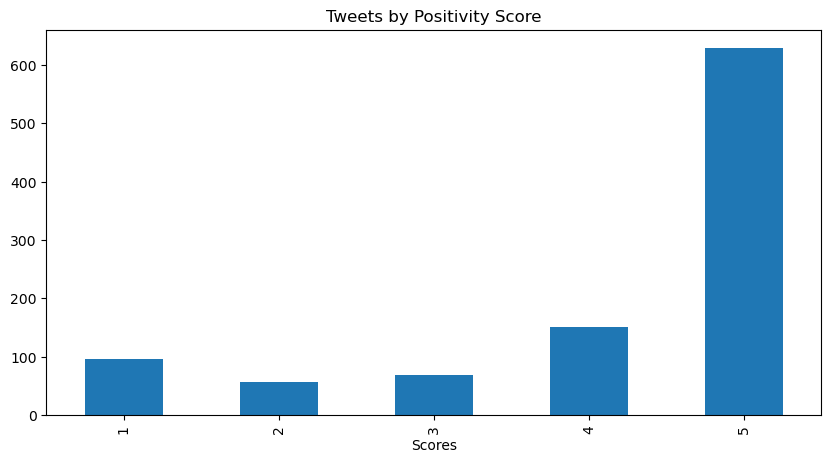

In [6]:
axis = df_train['Score'].value_counts().sort_index().plot(kind='bar', 
                                             title='Tweets by Positivity Score',
                                             figsize=(10,5))
axis.set_xlabel('Scores')
plt.show()

In [7]:
#1. Use the VADER model for sentiment analysis:

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
#Demonstrate NTLK functionality using an example: 

In [10]:
example = df['Text'][180]
print(example)

Very happy with the shipping and product. Great product and price.I am now hooked on cooking with vanilla beans. Very easy to cut and scrape and use.


In [11]:
tokens = nltk.word_tokenize(example)
filtered_tokens = [token for token in tokens if re.match('^[a-zA-Z]+$', token)]

print(filtered_tokens[:10])

['Very', 'happy', 'with', 'the', 'shipping', 'and', 'product', 'Great', 'product', 'and']


In [12]:
sia.polarity_scores(example)

{'neg': 0.064, 'neu': 0.628, 'pos': 0.308, 'compound': 0.8727}

In [13]:
#Test across entire dataset by running polarity scores:
res = {}
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    content = str(row['Text'])  # Ensure content is a string
    unique_id = row['unique_id']
    res[unique_id] = sia.polarity_scores(content)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
#Results of dataset training:
pd.DataFrame(res).T

,neg,neu,pos,compound
0,0.000,0.768,0.232,0.9684
1,0.089,0.766,0.144,0.7920
2,0.000,0.880,0.120,0.4588
3,0.009,0.827,0.163,0.9923
4,0.089,0.719,0.191,0.9421
...,...,...,...,...
995,0.059,0.757,0.184,0.9476
996,0.000,0.776,0.224,0.8597
997,0.120,0.735,0.145,0.2723
998,0.000,0.796,0.204,0.8957


In [15]:
vader_dataset = pd.DataFrame(res).T
vader_dataset = vader_dataset.reset_index().rename(columns={'index': 'unique_id'})
vader_dataset = vader_dataset.merge(df_train[['unique_id', 'Summary', 'Text', 'Score']], how='left', on='unique_id')

In [16]:
vader_dataset.head()

,unique_id,neg,neu,pos,compound,Summary,Text,Score
0,0,0.000,0.768,0.232,0.9684,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,5
1,1,0.089,0.766,0.144,0.7920,great kitty treats,My cat loves these treats. If ever I can't fin...,5
2,2,0.000,0.880,0.120,0.4588,COFFEE TASTE,A little less than I expected. It tends to ha...,3
3,3,0.009,0.827,0.163,0.9923,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...",2
4,4,0.089,0.719,0.191,0.9421,Great Taste . . .,and I want to congratulate the graphic artist ...,5


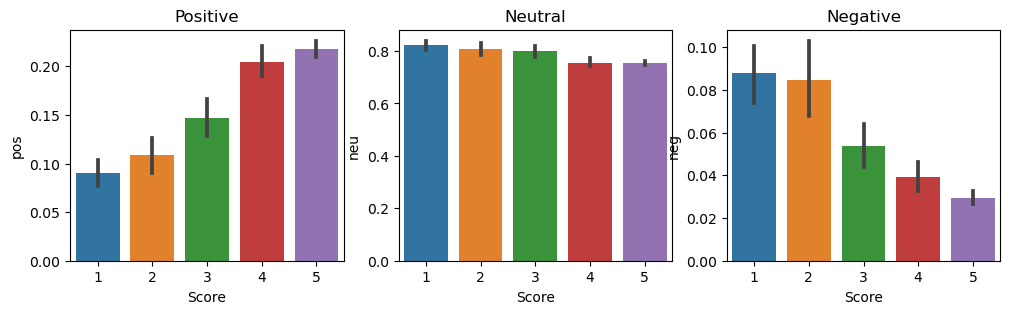

In [17]:
#Show results/accuracy as a graph:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vader_dataset, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vader_dataset, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vader_dataset, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

In [18]:
sia.polarity_scores(df['Text'][0])

{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'compound': 0.9684}

In [19]:
#2. Test using Roberta model:
#3. Test using Distilled Student Sentiment classifier model:

In [20]:
#Make sure to use version 0.13.3 of transformers for the AutoTokenizer to work:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax

In [21]:
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
roberta_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

C:\Users\Matthew\anaconda3\envs\iris\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [23]:
#Using transfer learning in these cases:
def polarity_scores_roberta(example):
    encoded_text = roberta_tokenizer(example, return_tensors='pt')
    output = roberta_model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [24]:
def polarity_scores_distilled_student_classifier(example):
    # Use the pipeline to obtain sentiment scores
    scores = distilled_student_sentiment_classifier(example)
    
    # Extract and format the sentiment scores
    scores_dict = {
        'dss_pos': scores[0][0]['score'],   # Negative sentiment score
        'dss_neg': scores[0][1]['score'],   # Neutral sentiment score
        'dss_neu': scores[0][2]['score']    # Positive sentiment score
    }
    return scores_dict

In [25]:
#Iterate over testing data sets for both models to obtain graphs:

In [26]:
roberta_res = {}
for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    try:
        content = str(row['Text'])
        unique_id = row['unique_id']
        scores_dict = polarity_scores_roberta(content)
        roberta_res[unique_id] = scores_dict
    except RuntimeError:
        print(f'Unsuccessful for id {unique_id}')


  0%|          | 0/1000 [00:00<?, ?it/s]

Unsuccessful for id 197
Unsuccessful for id 213
Unsuccessful for id 221
Unsuccessful for id 308
Unsuccessful for id 510
Unsuccessful for id 837


In [27]:
# Divide Distilled Student Classifier into chunk sizes of 512 because of indexing properties:
chunk_size = 512
dss_res = {}
for chunk_start in range(0, len(df_train), chunk_size):
    chunk_df = df_train.iloc[chunk_start:chunk_start+chunk_size]
    chunk_scores = {}
    
    for i, row in tqdm(chunk_df.iterrows(), total=len(chunk_df)):
        try:
            content = str(row['Text'])
            unique_id = row['unique_id']
            scores_dict = polarity_scores_distilled_student_classifier(content)
            chunk_scores[unique_id] = scores_dict
        except RuntimeError:
            print(f'Unsuccessful for id {unique_id}')
    
    dss_res.update(chunk_scores)


  0%|          | 0/512 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors


Unsuccessful for id 197
Unsuccessful for id 213
Unsuccessful for id 221
Unsuccessful for id 250
Unsuccessful for id 308
Unsuccessful for id 420
Unsuccessful for id 428
Unsuccessful for id 510


  0%|          | 0/488 [00:00<?, ?it/s]

Unsuccessful for id 517
Unsuccessful for id 658
Unsuccessful for id 837
Unsuccessful for id 857
Unsuccessful for id 895


In [28]:
roberta_res

{0: {'roberta_neg': 0.006663827,
  'roberta_neu': 0.0512016,
  'roberta_pos': 0.94213456},
 1: {'roberta_neg': 0.012858241,
  'roberta_neu': 0.064116016,
  'roberta_pos': 0.9230257},
 2: {'roberta_neg': 0.67468494,
  'roberta_neu': 0.29543132,
  'roberta_pos': 0.02988379},
 3: {'roberta_neg': 0.07757535,
  'roberta_neu': 0.643972,
  'roberta_pos': 0.27845266},
 4: {'roberta_neg': 0.008609253,
  'roberta_neu': 0.03490608,
  'roberta_pos': 0.9564847},
 5: {'roberta_neg': 0.018676069,
  'roberta_neu': 0.3973393,
  'roberta_pos': 0.5839846},
 6: {'roberta_neg': 0.0025822856,
  'roberta_neu': 0.0068965675,
  'roberta_pos': 0.9905212},
 7: {'roberta_neg': 0.034273475,
  'roberta_neu': 0.12131431,
  'roberta_pos': 0.8444122},
 8: {'roberta_neg': 0.31894806,
  'roberta_neu': 0.61227643,
  'roberta_pos': 0.06877547},
 9: {'roberta_neg': 0.015708838,
  'roberta_neu': 0.107214145,
  'roberta_pos': 0.877077},
 10: {'roberta_neg': 0.049773548,
  'roberta_neu': 0.32969257,
  'roberta_pos': 0.6205339

In [29]:
roberta_dataset = pd.DataFrame(roberta_res).T
roberta_dataset = roberta_dataset.reset_index().rename(columns={'index': 'unique_id'})
roberta_dataset = roberta_dataset.merge(df_train[['unique_id', 'Summary', 'Text', 'Score']], how='left', on='unique_id')

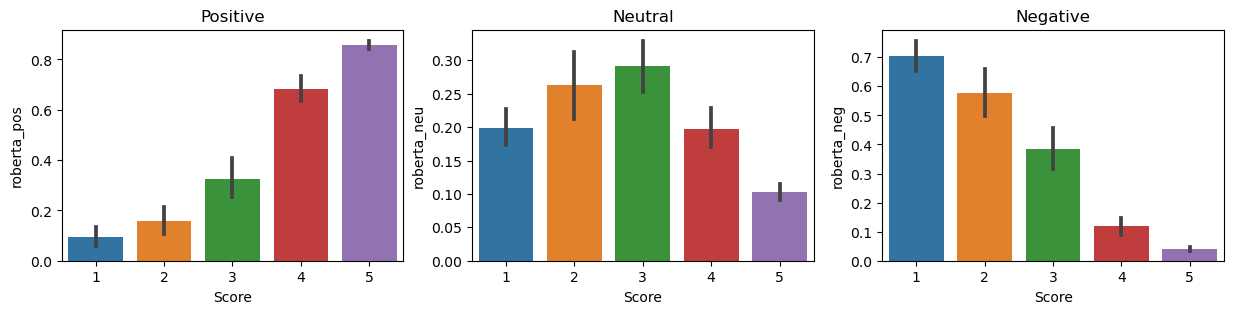

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
sns.barplot(data=roberta_dataset, x='Score', y='roberta_pos', ax=axs[0])
sns.barplot(data=roberta_dataset, x='Score', y='roberta_neu', ax=axs[1])
sns.barplot(data=roberta_dataset, x='Score', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

In [31]:
dss_res

{0: {'dss_pos': 0.7043991088867188,
  'dss_neg': 0.13175122439861298,
  'dss_neu': 0.16384971141815186},
 1: {'dss_pos': 0.6154907941818237,
  'dss_neg': 0.1632268726825714,
  'dss_neu': 0.22128228843212128},
 2: {'dss_pos': 0.3968121111392975,
  'dss_neg': 0.31257686018943787,
  'dss_neu': 0.29061099886894226},
 3: {'dss_pos': 0.44416558742523193,
  'dss_neg': 0.27662429213523865,
  'dss_neu': 0.2792101502418518},
 4: {'dss_pos': 0.7485164999961853,
  'dss_neg': 0.1763322651386261,
  'dss_neu': 0.07515120506286621},
 5: {'dss_pos': 0.4625658690929413,
  'dss_neg': 0.25344741344451904,
  'dss_neu': 0.2839866876602173},
 6: {'dss_pos': 0.9292197823524475,
  'dss_neg': 0.04043717309832573,
  'dss_neu': 0.030342968180775642},
 7: {'dss_pos': 0.6721920371055603,
  'dss_neg': 0.14064529538154602,
  'dss_neu': 0.18716269731521606},
 8: {'dss_pos': 0.6556366086006165,
  'dss_neg': 0.1953888237476349,
  'dss_neu': 0.14897461235523224},
 9: {'dss_pos': 0.3873897194862366,
  'dss_neg': 0.4927458

In [32]:
dss_dataset = pd.DataFrame(dss_res).T
dss_dataset = dss_dataset.reset_index().rename(columns={'index': 'unique_id'})
dss_dataset = dss_dataset.merge(df_train[['unique_id', 'Summary', 'Text', 'Score']], how='left', on='unique_id')

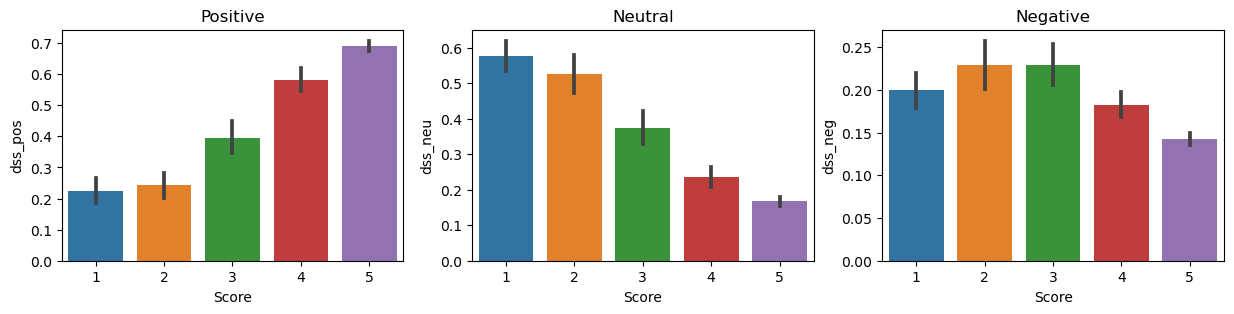

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
sns.barplot(data=dss_dataset, x='Score', y='dss_pos', ax=axs[0])
sns.barplot(data=dss_dataset, x='Score', y='dss_neu', ax=axs[1])
sns.barplot(data=dss_dataset, x='Score', y='dss_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

In [34]:
#Merge 2 above datasets to the vader_dataset and reformat to get total comparison graph:

In [35]:
total_dataset = vader_dataset

In [36]:
for unique_id, scores_dict in roberta_res.items():
    for key, value in scores_dict.items():
        total_dataset.loc[unique_id, key] = value

In [37]:
for unique_id, scores_dict in dss_res.items():
    for key, value in scores_dict.items():
        total_dataset.loc[unique_id, key] = value

In [38]:
total_dataset = total_dataset.rename(columns={'pos': 'vader_pos'})
total_dataset = total_dataset.rename(columns={'neg': 'vader_neg'})
total_dataset = total_dataset.rename(columns={'neu': 'vader_neu'})

In [39]:
total_dataset

,unique_id,vader_neg,vader_neu,vader_pos,compound,Summary,Text,Score,roberta_neg,roberta_neu,roberta_pos,dss_pos,dss_neg,dss_neu
0,0,0.000,0.768,0.232,0.9684,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...,5,0.006664,0.051202,0.942135,0.704399,0.131751,0.163850
1,1,0.089,0.766,0.144,0.7920,great kitty treats,My cat loves these treats. If ever I can't fin...,5,0.012858,0.064116,0.923026,0.615491,0.163227,0.221282
2,2,0.000,0.880,0.120,0.4588,COFFEE TASTE,A little less than I expected. It tends to ha...,3,0.674685,0.295431,0.029884,0.396812,0.312577,0.290611
3,3,0.009,0.827,0.163,0.9923,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin...",2,0.077575,0.643972,0.278453,0.444166,0.276624,0.279210
4,4,0.089,0.719,0.191,0.9421,Great Taste . . .,and I want to congratulate the graphic artist ...,5,0.008609,0.034906,0.956485,0.748516,0.176332,0.075151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.059,0.757,0.184,0.9476,it is cheap caviar,let's face it not spending a lot on this cavia...,3,0.499539,0.389639,0.110822,0.489292,0.374919,0.135789
996,996,0.000,0.776,0.224,0.8597,Fantastic,Out of all of the hot chocolate kcups that I h...,5,0.007878,0.020183,0.971939,0.781407,0.172817,0.045776
997,997,0.120,0.735,0.145,0.2723,Great price!,"What's not to like? Great price, free shipping...",5,0.004090,0.038562,0.957347,0.639362,0.158997,0.201640
998,998,0.000,0.796,0.204,0.8957,"NOT for everybody, though",I love it.<br /><br />But at least 40 per cent...,5,0.080188,0.168559,0.751253,0.862808,0.076130,0.061063


C:\Users\Matthew\anaconda3\envs\iris\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Matthew\anaconda3\envs\iris\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Matthew\anaconda3\envs\iris\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Matthew\anaconda3\envs\iris\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a le

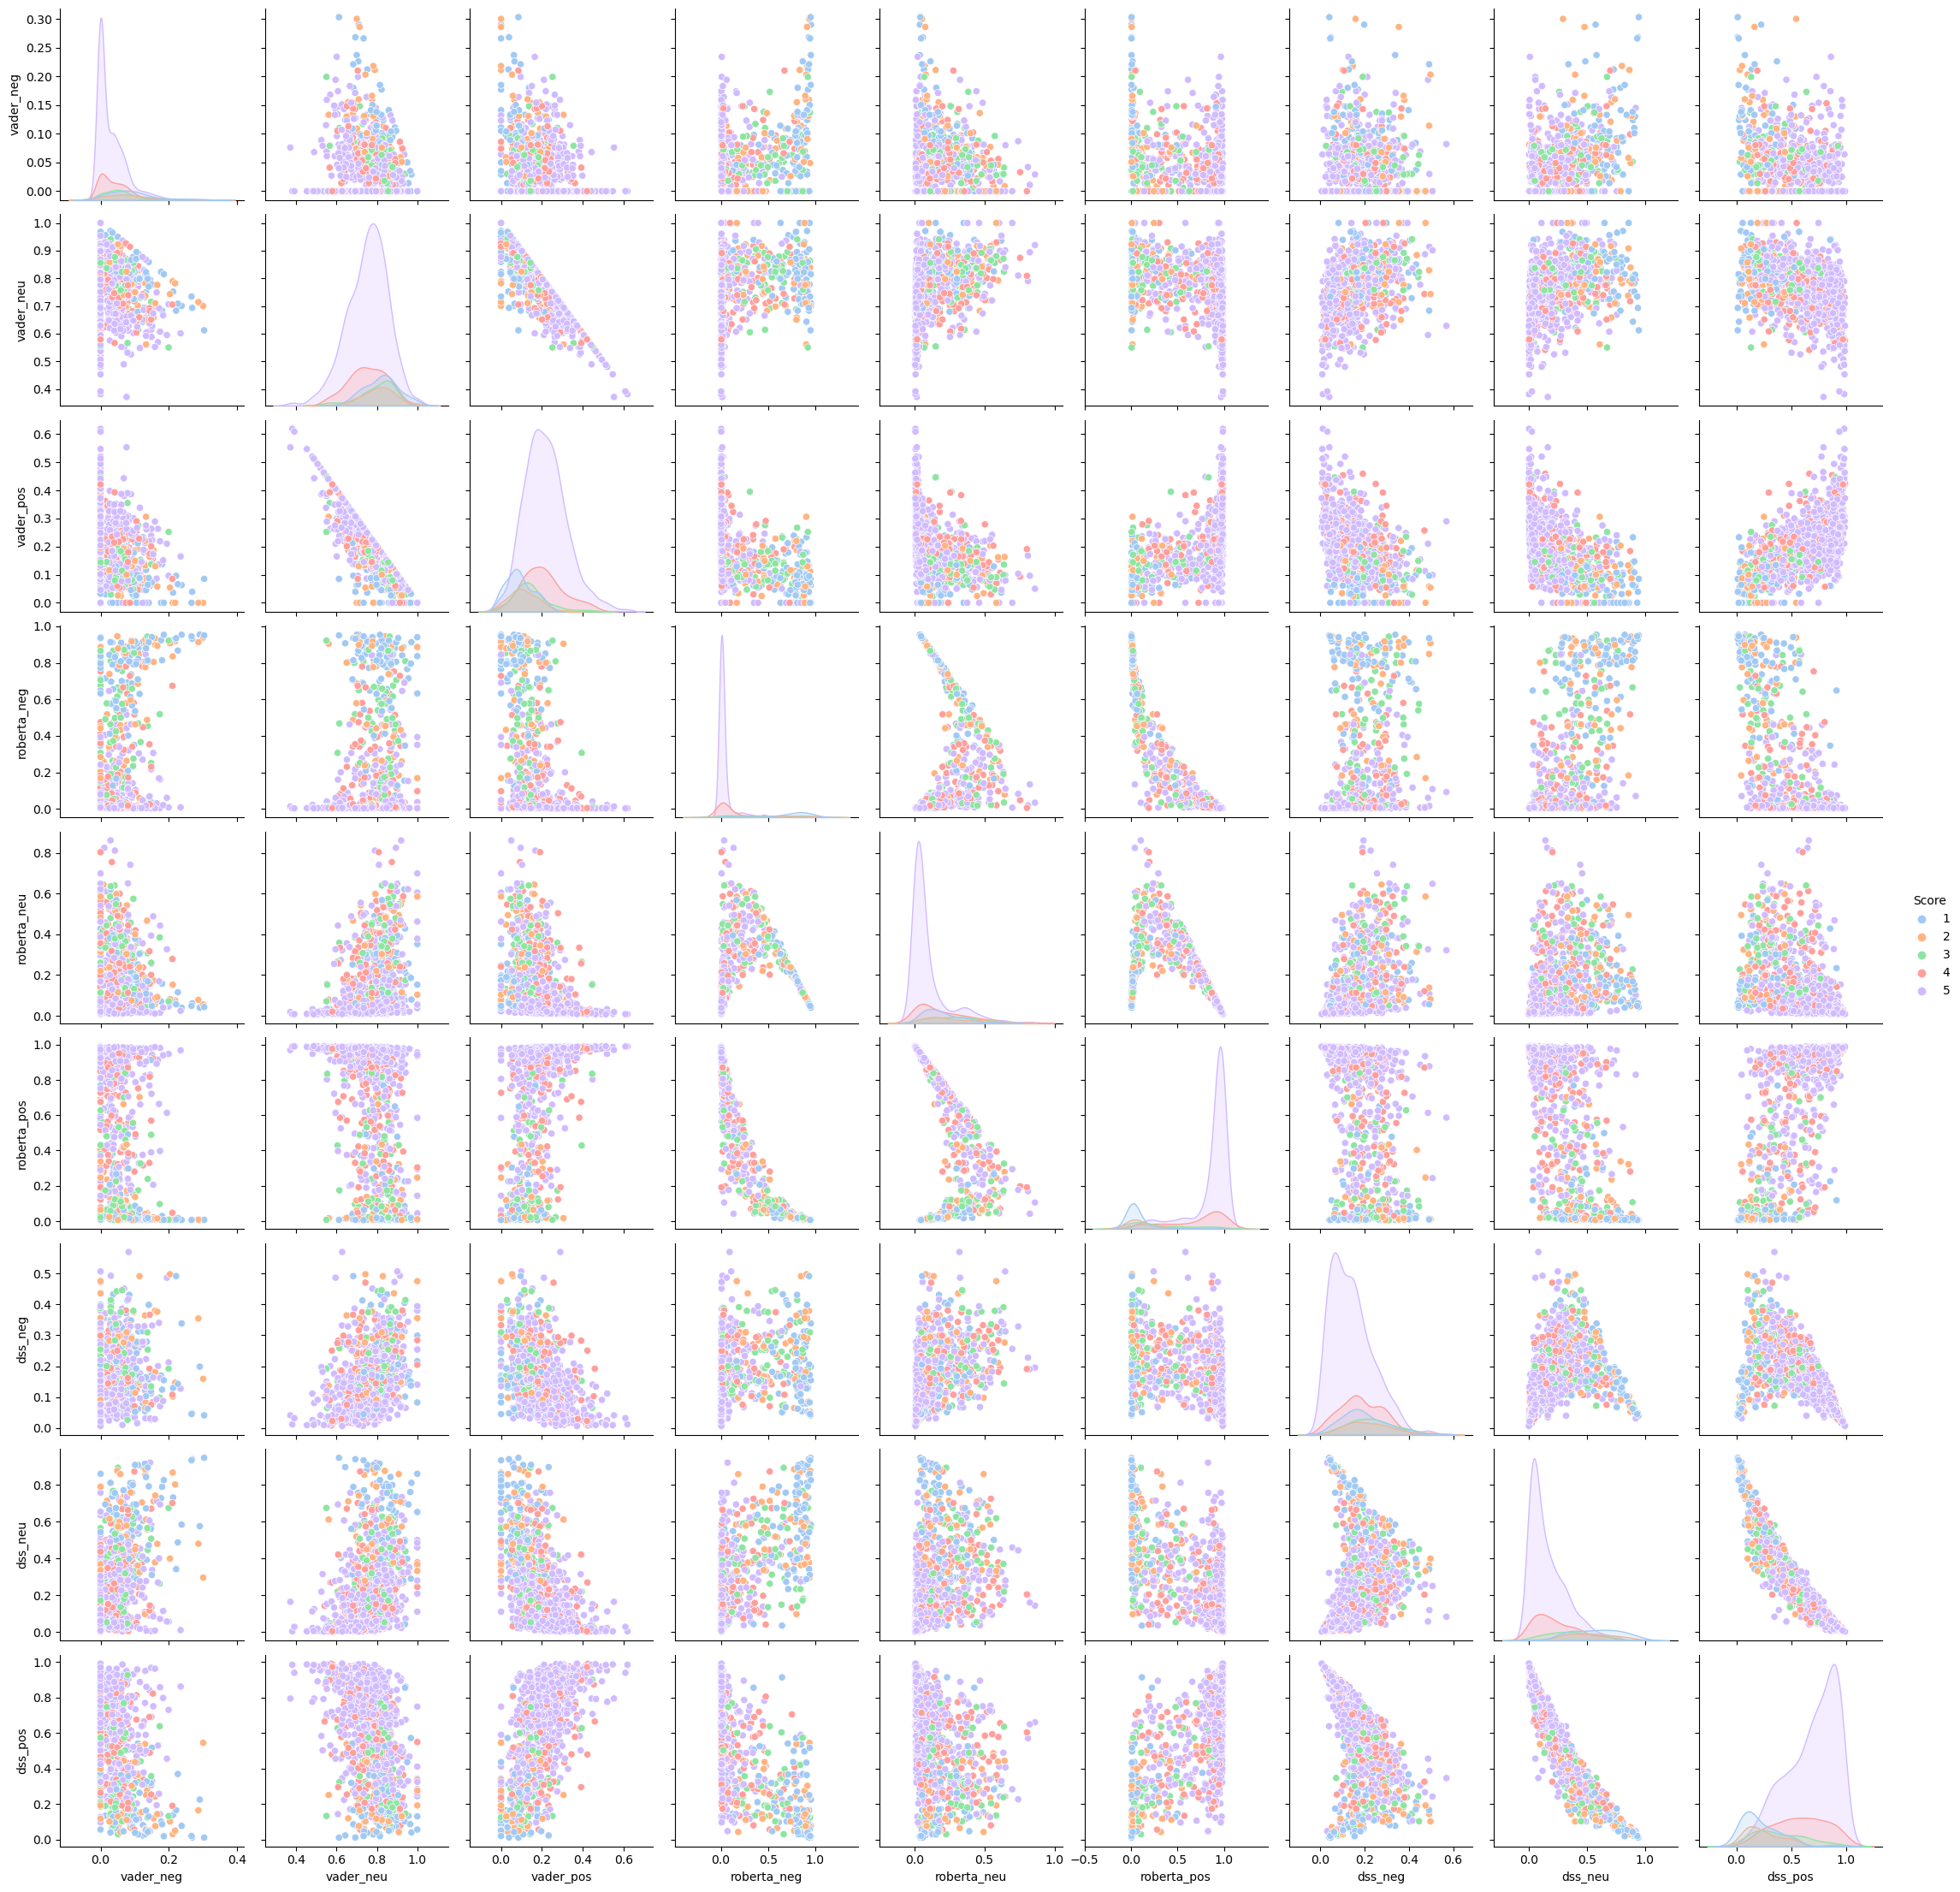

In [40]:
sns.pairplot(data=total_dataset,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos',
                  'dss_neg', 'dss_neu', 'dss_pos'],
            hue='Score',
            palette='pastel')
plt.show()